# Conformalized Early Stopping -- Regression

- We implement the conformalized early stopping algorithm as well as the benchmark methods on the Combined Cycle Power Plant Data Set provided by Pınar Tüfekci and Heysem Kaya and hosted by the UCI Machine Learning Repository [1][2]. 

**Note: the following dataset description is copied from UCI Machine Learning Repository. **
The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.
For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.

- The conformalized early stopping method is compared with two benchmarks: 1) a normal setting where we split the data into training, validation, and calibration sets. The three subsets are disjoint and are used for training the deep neural network models, choosing the early stopping models, and calibration respectively; 2) a setting where the data is split into only training set and calibration set only. The calibration set is used for both picking the best models and calibrating prediction intervals. In this setting we ignore the requirement for data exchangeability, therefore should expect the marginal coverage to fail to reach the nominal level, especially when the calibration set is small and single test sample has significant contribution to the loss function. 

- For the first benchmark method, we randomly selected 1000 training samples, 200 validation samples, and test the prediction interval coverage over 100 test samples using 10 and 100 calibration data respectively. For the conformalized early stopping method, we merge the training and validation samples for training. The calibration samples are used together with new test point to select the best models. For the other benchmark method ignoring exchangeability, we use 1200 samples for training, and use the calibration samples for model selection AND conformal prediction. For all three methods, the models are trained $T_{\max} = 200$ epochs and saved every snapshot. All experiments are repeated 30 times with randomly drawn subsets. The results are summarized in Table \ref{table:reg_result}. 


[1] Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615, https://www.sciencedirect.com/science/article/abs/pii/S0142061514000908?via%3Dihub. 

[2] Heysem Kaya, Pınar Tüfekci , Sadık Fikret Gürgen: Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine, Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai)

In [1]:
!pip install numdifftools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import torch as th
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sympy import *
import pathlib
import pdb
import matplotlib.pyplot as plt

from ConformalizedES.method import CES_regression
from ConformalizedES.networks import mse_model, MSE_loss
from ConformalizedES.inference import Conformal_PI
from third_party.coverage import *

In [5]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

## Loading the dataset

In [6]:
class PrepareData(Dataset):

    def __init__(self, X, y, scale_X=False):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()


In [7]:
data = pd.read_excel("Folds5x2_pp.xlsx")
data = data.apply(pd.to_numeric)

X = np.array(data[['AT','V','AP','RH']])
y = np.array(data['PE'])

## The benchmark method

In [48]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 1000
n_val = 200
n_cal = 10
n_test = 100 
method_ = 'Benchmark'

seed = 2322
np.random.seed(seed)
th.manual_seed(seed)

# split the data into proper training, validation, and calibration set, set test data aside 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
idx_test = np.random.permutation(n_test)
X_test = X_test[idx_test]
y_test = y_test[idx_test]

idx = np.random.permutation(n_train+n_val+n_cal)
idx_train_BM, idx_val_BM, idx_cal_BM = idx[:n_train], idx[n_train:n_val+n_train], idx[n_val+n_train: n_val+n_train + n_cal]
X_train_BM, y_train_BM = X_train[idx_train_BM], y_train[idx_train_BM]
X_val_BM, y_val_BM = X_train[idx_val_BM], y_train[idx_val_BM]
X_cal_BM, y_cal_BM = X_train[idx_cal_BM], y_train[idx_cal_BM]

print("Size (BM): train (%d, %d), validationn (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM.shape[0], X_train_BM.shape[1], 
       X_val_BM.shape[0], X_val_BM.shape[1], 
       X_cal_BM.shape[0], X_cal_BM.shape[1], 
       X_test.shape[0], X_test.shape[1]))

Size (BM): train (1000, 4), validationn (200, 4), calibration (10, 4), test (100, 4)


In [49]:
# set the hyperparameters
batch_size = 16
dropout = 0
num_epochs = 200
lr = 0.005
wd = 1e-5

In [50]:
train_loader = DataLoader(PrepareData(X_train_BM, y_train_BM, scale_X=False), batch_size=batch_size)
val_loader = DataLoader(PrepareData(X_val_BM, y_val_BM, scale_X=False), batch_size=batch_size, drop_last = True) 
calib_loader = DataLoader(PrepareData(X_cal_BM, y_cal_BM, scale_X=False), batch_size=1, shuffle = False, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)


# intialize the model
in_shape = X_train_BM.shape[1]
hidden_layer_size = 128

# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size)
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [51]:
# initialization
BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=val_loader, criterion= MSE_loss, optimizer=optimizer, verbose = False)

In [52]:
# Train the model and save snapshots 
save_every = 1    # Save model after every few epoches
BM_reg.full_train(save_dir = './content', save_every = save_every)

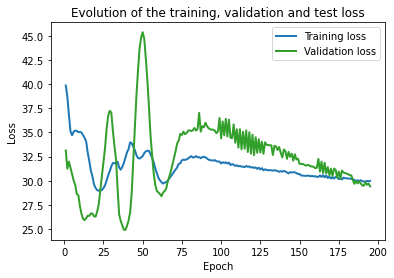

In [53]:
plot_loss(BM_reg.train_loss_history[5:], BM_reg.val_loss_history[5:])

In [54]:
# compute validation loss (burn-out first 20 epochs)
val_loss = np.mean(BM_reg.val_loss_history[-20:])

In [55]:
# Check the best models
bm_loss, bm_model, loss_history = BM_reg.select_model()

In [56]:
# Split conformal prediction 
alpha = 0.1

# store coverage indicator for every test sample
coverage_BM = []
# store size of the prediction interval 
size_BM = []
# store test loss
test_losses_BM = []
# store prediction intervals for every test sample
pi_BM = []

# initialize
C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # find prediction interval
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model)
  pi_BM.append(benchmarkPI)
  # find size and coverage indicator
  size_BM.append(benchmarkPI[0]._measure)
  coverage_BM.append(response in benchmarkPI[0])
  # evaluate the out of sample losses
  ## load the best model
  BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=val_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)
  BM_reg.net.load_state_dict(torch.load(bm_model, map_location=device))
  ## compute loss on test samples
  test_loss = BM_reg.get_loss(input, response)
  test_losses_BM.append(test_loss)

100%|██████████| 100/100 [00:00<00:00, 171.89it/s]


In [57]:
# store conditional coverage
wsc_coverages_BM = []

# compute conditional coverage
for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM, M=100, delta = 0.1)
  wsc_coverages_BM.append(wsc_coverage)

In [58]:
print("The marginal coverage rate is (BM) {}".format(sum(coverage_BM)/len(coverage_BM)))
print("The conditional coverage rate is (BM) {}".format(sum(wsc_coverages_BM)/len(wsc_coverages_BM)))
print("The average size is (BM) {}".format(sum(size_BM)/len(size_BM)))
print("The test loss is (BM) {}".format(sum(test_losses_BM)/len(test_losses_BM)))
print("The validation loss is (BM) {}".format(val_loss))

The marginal coverage rate is (BM) 0.93
The conditional coverage rate is (BM) 0.9875
The average size is (BM) 18.7617797851563
The test loss is (BM) 31.855712890625
The validation loss is (BM) 30.104652106761932


## Conforamlized early stopping

In [8]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 1000
n_val = 200
n_cal = 10
n_test = 100 
method_ = 'CES'

seed = 2322
np.random.seed(seed)
th.manual_seed(seed)

# split the data into proper training, validation, and calibration set, set test data aside 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
idx_test = np.random.permutation(n_test)
X_test = X_test[idx_test]
y_test = y_test[idx_test]

idx = np.random.permutation(n_train+n_val+n_cal)
idx_train_CES, idx_cal_CES = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]
X_train_CES, y_train_CES = X_train[idx_train_CES], y_train[idx_train_CES]
X_cal_CES, y_cal_CES = X_train[idx_cal_CES], y_train[idx_cal_CES]

print("Size (CES): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_CES.shape[0], X_train_CES.shape[1], X_cal_CES.shape[0], X_cal_CES.shape[1], 
      X_test.shape[0], X_test.shape[1]))

Size (CES): train (1200, 4), calibration (10, 4), test (100, 4)


In [9]:
# set the hyperparameters
batch_size = 16
hidden_layer_size = 128
dropout = 0
num_epochs = 200
lr = 0.005
wd = 1e-5

num_workers = 0

In [10]:
train_loader = DataLoader(PrepareData(X_train_CES, y_train_CES, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_CES, y_cal_CES, scale_X=False), batch_size=1, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

# intialize the model
in_shape = X_train_CES.shape[1]
hidden_layer_size = 128

# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size)
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [11]:
# initialization
CES_reg = CES_regression(mod, 
                         device, 
                         train_loader, 
                         batch_size=batch_size, 
                         max_epoch = num_epochs, 
                         learning_rate=lr, 
                         val_loader=calib_loader, 
                         criterion= MSE_loss, optimizer=optimizer,
                         verbose = False)

In [12]:
# Train the model and save snapshots 
save_every = 1    # Save model after every few epoches
CES_reg.full_train(save_dir = './content', save_every = save_every)

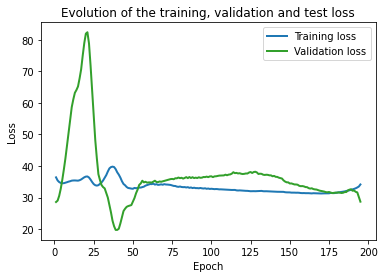

In [13]:
plot_loss(CES_reg.train_loss_history[5:], CES_reg.val_loss_history[5:])

In [14]:
# compute validation loss (burn-out first 20 epochs)
val_loss = np.mean(CES_reg.val_loss_history[-20:])

In [15]:
# Split conformal prediction 
alpha = 0.1

# store coverage indicator for every test sample
coverage_CES = []
# store coverage indicator (aovid empty) for every test sample
coverage_CES_noempty = []
# store size of the prediction interval 
size_CES = []
# store size (aovid empty) of the prediction interval 
size_CES_noempty = []
# store test loss
test_losses_CES = []
# store prediction intervals for every test sample
pi_CES = []
# store prediction intervals (avoid empty) for every test sample
pi_CES_noempty = []


# initialize
C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # find the best models
  best_models = CES_reg.select_model(input)
  # apply CP using the best models
  CESPI = C_PI.CES_icp(input, best_models, method = 'cvxh')
  CESPI_noempty = C_PI.CES_icp(input, best_models, method = 'cvxh', no_empty = True, mod = CES_reg)
  pi_CES.append(CESPI)
  pi_CES_noempty.append(CESPI_noempty)

  # compute the size of the prediction interval
  size_single = sum([intv._measure for intv in CESPI])
  size_CES.append(size_single)
  # compute the coverage of the prediction interval
  coverage_single = sum([response in intv for intv in CESPI]) > 0
  coverage_CES.append(coverage_single)
    
  size_CES_noempty.append(CESPI_noempty[0]._measure)
  coverage_CES_noempty.append(response in CESPI_noempty[0])

  # compute the test loss 
  _, best_models_bs,_ = CES_reg.select_model()
  testonly_mod = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=calib_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)
  testonly_mod.net.load_state_dict(torch.load(best_models_bs, map_location=device))
  test_loss = testonly_mod.get_loss(input, response)
  test_losses_CES.append(test_loss)

  1%|          | 1/100 [00:10<17:18, 10.49s/it]

elapse time (selecting best models):10.436424493789673


  2%|▏         | 2/100 [00:20<16:38, 10.19s/it]

elapse time (selecting best models):9.915138959884644


  3%|▎         | 3/100 [00:30<16:24, 10.15s/it]

elapse time (selecting best models):10.050424575805664


  4%|▍         | 4/100 [00:41<16:51, 10.53s/it]

elapse time (selecting best models):11.055197477340698


  5%|▌         | 5/100 [00:51<16:25, 10.38s/it]

elapse time (selecting best models):10.011450290679932


  6%|▌         | 6/100 [01:02<16:40, 10.65s/it]

elapse time (selecting best models):11.10840129852295


  7%|▋         | 7/100 [01:13<16:13, 10.46s/it]

elapse time (selecting best models):10.017600297927856


  8%|▊         | 8/100 [01:23<16:00, 10.44s/it]

elapse time (selecting best models):10.325133323669434


  9%|▉         | 9/100 [01:33<15:41, 10.34s/it]

elapse time (selecting best models):10.053033351898193


 10%|█         | 10/100 [01:46<16:36, 11.07s/it]

elapse time (selecting best models):12.659145593643188


 11%|█         | 11/100 [01:56<15:56, 10.75s/it]

elapse time (selecting best models):9.9457848072052


 12%|█▏        | 12/100 [02:13<18:34, 12.66s/it]

elapse time (selecting best models):16.980746030807495


 13%|█▎        | 13/100 [02:27<19:06, 13.18s/it]

elapse time (selecting best models):14.280762195587158
elapse time (selecting best models):16.527043342590332


 15%|█▌        | 15/100 [02:56<19:03, 13.45s/it]

elapse time (selecting best models):11.455119371414185


 16%|█▌        | 16/100 [03:06<17:26, 12.46s/it]

elapse time (selecting best models):10.056183576583862


 17%|█▋        | 17/100 [03:17<16:45, 12.11s/it]

elapse time (selecting best models):11.239293098449707


 18%|█▊        | 18/100 [03:28<16:12, 11.86s/it]

elapse time (selecting best models):11.21414852142334


 19%|█▉        | 19/100 [03:39<15:37, 11.57s/it]

elapse time (selecting best models):10.821710586547852


 20%|██        | 20/100 [03:52<15:51, 11.90s/it]

elapse time (selecting best models):12.602816581726074


 21%|██        | 21/100 [04:03<15:28, 11.75s/it]

elapse time (selecting best models):11.330555438995361


 22%|██▏       | 22/100 [04:15<15:12, 11.70s/it]

elapse time (selecting best models):11.512882709503174


 23%|██▎       | 23/100 [04:31<16:48, 13.09s/it]

elapse time (selecting best models):16.278929471969604


 24%|██▍       | 24/100 [04:41<15:25, 12.18s/it]

elapse time (selecting best models):10.012937784194946


 25%|██▌       | 25/100 [04:54<15:27, 12.36s/it]

elapse time (selecting best models):12.668955326080322


 26%|██▌       | 26/100 [05:06<14:59, 12.15s/it]

elapse time (selecting best models):11.557357788085938


 27%|██▋       | 27/100 [05:21<16:00, 13.16s/it]

elapse time (selecting best models):15.431249618530273


 28%|██▊       | 28/100 [05:32<14:53, 12.41s/it]

elapse time (selecting best models):10.58160662651062


 29%|██▉       | 29/100 [05:43<14:20, 12.12s/it]

elapse time (selecting best models):11.372818946838379


 30%|███       | 30/100 [05:57<14:36, 12.52s/it]

elapse time (selecting best models):13.390596151351929


 31%|███       | 31/100 [06:09<14:09, 12.31s/it]

elapse time (selecting best models):11.70849871635437


 32%|███▏      | 32/100 [06:24<15:02, 13.27s/it]

elapse time (selecting best models):15.440382480621338


 33%|███▎      | 33/100 [06:37<14:39, 13.13s/it]

elapse time (selecting best models):12.705931186676025


 34%|███▍      | 34/100 [06:50<14:31, 13.21s/it]

elapse time (selecting best models):13.324859380722046


 35%|███▌      | 35/100 [07:03<14:16, 13.18s/it]

elapse time (selecting best models):13.029533386230469


 36%|███▌      | 36/100 [07:16<13:59, 13.11s/it]

elapse time (selecting best models):12.863839149475098


 37%|███▋      | 37/100 [07:29<13:43, 13.07s/it]

elapse time (selecting best models):12.890808582305908


 38%|███▊      | 38/100 [07:41<13:02, 12.61s/it]

elapse time (selecting best models):11.453314304351807


 39%|███▉      | 39/100 [07:54<13:02, 12.82s/it]

elapse time (selecting best models):13.23006534576416


 40%|████      | 40/100 [08:05<12:07, 12.12s/it]

elapse time (selecting best models):10.360580444335938


 41%|████      | 41/100 [08:15<11:18, 11.50s/it]

elapse time (selecting best models):10.002118110656738


 42%|████▏     | 42/100 [08:25<10:44, 11.11s/it]

elapse time (selecting best models):10.114845752716064


 43%|████▎     | 43/100 [08:35<10:16, 10.81s/it]

elapse time (selecting best models):10.005556344985962


 44%|████▍     | 44/100 [08:45<09:55, 10.63s/it]

elapse time (selecting best models):10.112185955047607


 45%|████▌     | 45/100 [08:59<10:41, 11.66s/it]

elapse time (selecting best models):13.99101209640503


 46%|████▌     | 46/100 [09:09<10:04, 11.20s/it]

elapse time (selecting best models):10.063684463500977


 47%|████▋     | 47/100 [09:19<09:35, 10.85s/it]

elapse time (selecting best models):9.97790813446045


 48%|████▊     | 48/100 [09:30<09:12, 10.62s/it]

elapse time (selecting best models):10.008571147918701


 49%|████▉     | 49/100 [09:40<08:52, 10.44s/it]

elapse time (selecting best models):9.920722246170044


 50%|█████     | 50/100 [09:50<08:38, 10.36s/it]

elapse time (selecting best models):10.104101181030273


 51%|█████     | 51/100 [10:00<08:31, 10.43s/it]

elapse time (selecting best models):10.542310953140259


 52%|█████▏    | 52/100 [10:10<08:15, 10.33s/it]

elapse time (selecting best models):10.014532089233398


 53%|█████▎    | 53/100 [10:20<08:01, 10.24s/it]

elapse time (selecting best models):9.973531246185303


 54%|█████▍    | 54/100 [10:31<07:49, 10.22s/it]

elapse time (selecting best models):10.085589170455933


 55%|█████▌    | 55/100 [10:41<07:37, 10.16s/it]

elapse time (selecting best models):9.955420970916748


 56%|█████▌    | 56/100 [10:51<07:25, 10.13s/it]

elapse time (selecting best models):9.991199493408203


 57%|█████▋    | 57/100 [11:01<07:14, 10.11s/it]

elapse time (selecting best models):9.989084959030151


 58%|█████▊    | 58/100 [11:11<07:04, 10.10s/it]

elapse time (selecting best models):9.964951753616333


 59%|█████▉    | 59/100 [11:21<06:53, 10.09s/it]

elapse time (selecting best models):10.015182733535767


 60%|██████    | 60/100 [11:31<06:43, 10.09s/it]

elapse time (selecting best models):9.997354507446289


 61%|██████    | 61/100 [11:41<06:32, 10.07s/it]

elapse time (selecting best models):9.941966772079468


 62%|██████▏   | 62/100 [11:51<06:22, 10.06s/it]

elapse time (selecting best models):9.96541976928711


 63%|██████▎   | 63/100 [12:01<06:11, 10.04s/it]

elapse time (selecting best models):9.916118383407593


 64%|██████▍   | 64/100 [12:11<06:02, 10.06s/it]

elapse time (selecting best models):10.032402038574219


 65%|██████▌   | 65/100 [12:21<05:52, 10.08s/it]

elapse time (selecting best models):10.043062925338745


 66%|██████▌   | 66/100 [12:31<05:43, 10.10s/it]

elapse time (selecting best models):10.062437772750854


 67%|██████▋   | 67/100 [12:42<05:33, 10.09s/it]

elapse time (selecting best models):9.966730833053589


 68%|██████▊   | 68/100 [12:52<05:22, 10.09s/it]

elapse time (selecting best models):10.008476972579956


 69%|██████▉   | 69/100 [13:02<05:13, 10.10s/it]

elapse time (selecting best models):10.024999856948853


 70%|███████   | 70/100 [13:12<05:02, 10.09s/it]

elapse time (selecting best models):10.005483627319336


 71%|███████   | 71/100 [13:22<04:52, 10.09s/it]

elapse time (selecting best models):10.027994394302368


 72%|███████▏  | 72/100 [13:32<04:45, 10.21s/it]

elapse time (selecting best models):10.409433841705322


 73%|███████▎  | 73/100 [13:42<04:33, 10.13s/it]

elapse time (selecting best models):9.88740086555481


 74%|███████▍  | 74/100 [13:52<04:22, 10.11s/it]

elapse time (selecting best models):9.967591285705566


 75%|███████▌  | 75/100 [14:02<04:11, 10.06s/it]

elapse time (selecting best models):9.895063638687134


 76%|███████▌  | 76/100 [14:12<04:01, 10.07s/it]

elapse time (selecting best models):10.041608095169067


 77%|███████▋  | 77/100 [14:22<03:51, 10.08s/it]

elapse time (selecting best models):9.998205423355103


 78%|███████▊  | 78/100 [14:33<03:41, 10.06s/it]

elapse time (selecting best models):9.955810070037842


 79%|███████▉  | 79/100 [14:43<03:31, 10.08s/it]

elapse time (selecting best models):10.03644323348999


 80%|████████  | 80/100 [14:53<03:20, 10.04s/it]

elapse time (selecting best models):9.873793363571167


 81%|████████  | 81/100 [15:03<03:11, 10.06s/it]

elapse time (selecting best models):10.05242395401001


 82%|████████▏ | 82/100 [15:13<03:01, 10.10s/it]

elapse time (selecting best models):10.11866307258606


 83%|████████▎ | 83/100 [15:23<02:51, 10.11s/it]

elapse time (selecting best models):10.051124572753906


 84%|████████▍ | 84/100 [15:33<02:41, 10.11s/it]

elapse time (selecting best models):10.02784252166748


 85%|████████▌ | 85/100 [15:43<02:31, 10.10s/it]

elapse time (selecting best models):10.036806344985962


 86%|████████▌ | 86/100 [15:53<02:21, 10.09s/it]

elapse time (selecting best models):9.98328185081482


 87%|████████▋ | 87/100 [16:03<02:10, 10.08s/it]

elapse time (selecting best models):9.987513065338135


 88%|████████▊ | 88/100 [16:13<02:00, 10.05s/it]

elapse time (selecting best models):9.934937477111816


 89%|████████▉ | 89/100 [16:23<01:50, 10.09s/it]

elapse time (selecting best models):10.109469890594482


 90%|█████████ | 90/100 [16:34<01:40, 10.08s/it]

elapse time (selecting best models):9.95806336402893


 91%|█████████ | 91/100 [16:44<01:30, 10.11s/it]

elapse time (selecting best models):10.100867986679077


 92%|█████████▏| 92/100 [16:54<01:22, 10.27s/it]

elapse time (selecting best models):10.560609340667725


 93%|█████████▎| 93/100 [17:05<01:11, 10.24s/it]

elapse time (selecting best models):10.089448690414429


 94%|█████████▍| 94/100 [17:15<01:01, 10.21s/it]

elapse time (selecting best models):10.057751893997192


 95%|█████████▌| 95/100 [17:25<00:50, 10.20s/it]

elapse time (selecting best models):10.093493700027466


 96%|█████████▌| 96/100 [17:35<00:40, 10.19s/it]

elapse time (selecting best models):10.097583055496216


 97%|█████████▋| 97/100 [17:45<00:30, 10.18s/it]

elapse time (selecting best models):10.055855989456177


 98%|█████████▊| 98/100 [17:56<00:20, 10.23s/it]

elapse time (selecting best models):10.241909265518188


 99%|█████████▉| 99/100 [18:06<00:10, 10.19s/it]

elapse time (selecting best models):10.025203943252563


100%|██████████| 100/100 [18:16<00:00, 10.97s/it]

elapse time (selecting best models):10.492497444152832


In [16]:
# store conditional coverage  
wsc_coverages_CES = []
# store conditional (avoid empty) coverage  
wsc_coverages_CES_noempty = []
for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_CES, M=100, delta = 0.1)
  wsc_coverages_CES.append(wsc_coverage)
  wsc_coverage_noempty = wsc_unbiased(X_test, y_test, pi_CES_noempty, M=100, delta = 0.1)
  wsc_coverages_CES_noempty.append(wsc_coverage_noempty)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
print("The marginal coverage rate is (CES) {}".format(sum(coverage_CES)/len(coverage_CES)))
print("The conditional coverage rate is (CES) {}".format(np.nanmean(wsc_coverages_CES)))
print("The average size is (CES) {}".format(sum(size_CES)/len(size_CES)))
print("The test loss is (CES) {}".format(sum(test_losses_CES)/len(test_losses_CES)))
print("The validation loss is (CES) {}".format(val_loss))


print("The marginal coverage rate (avoid empty) is (CES) {}".format(sum(coverage_CES_noempty)/len(coverage_CES_noempty)))
print("The conditional coverage rate (avoid empty) is (CES) {}".format(np.nanmean(wsc_coverages_CES_noempty)))
print("The average size (avoid empty) is (CES) {}".format(sum(size_CES)/len(size_CES)))

The marginal coverage rate is (CES) 0.95
The conditional coverage rate is (CES) 1.0
The average size is (CES) 32.5740
The test loss is (CES) 34.48003005981445
The validation loss is (CES) 31.559921892955906
The marginal coverage rate (avoid empty) is (CES) 0.95
The conditional coverage rate (avoid empty) is (CES) 1.0
The average size (avoid empty) is (CES) 32.5740


## The benchmark method ignoring exchangeability

In [33]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 1000
n_val = 200
n_cal = 10
n_test = 100 
method_ = 'Benchmark_noexc'

seed = 2322
np.random.seed(seed)
th.manual_seed(seed)

# split the data into proper training, validation, and calibration set, set test data aside 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
idx_test = np.random.permutation(n_test)
X_test = X_test[idx_test]
y_test = y_test[idx_test]

idx = np.random.permutation(n_train+n_val+n_cal)
idx_train_BM_noexc, idx_cal_BM_noexc = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]
X_train_BM_noexc, y_train_BM_noexc = X_train[idx_train_BM_noexc], y_train[idx_train_BM_noexc]
X_cal_BM_noexc, y_cal_BM_noexc = X_train[idx_cal_BM_noexc], y_train[idx_cal_BM_noexc]

print("Size (BM_noexc): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM_noexc.shape[0], X_train_BM_noexc.shape[1], 
       X_cal_BM_noexc.shape[0], X_cal_BM_noexc.shape[1], 
       X_test.shape[0], X_test.shape[1]))


Size (BM_noexc): train (1200, 4), calibration (10, 4), test (100, 4)


In [34]:
# set the hyperparameters
batch_size = 16
dropout = 0
num_epochs = 200
lr = 0.005
wd = 1e-5

In [36]:
train_loader = DataLoader(PrepareData(X_train_BM_noexc, y_train_BM_noexc, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_BM_noexc, y_cal_BM_noexc, scale_X=False), batch_size=1, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

# intialize the model
in_shape = X_train_BM_noexc.shape[1]
hidden_layer_size = 128

# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size)
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [37]:
# intiialization
BM_reg_noexc = CES_regression(mod, 
                              device, 
                              train_loader, 
                              batch_size=batch_size, 
                              max_epoch = num_epochs, 
                              learning_rate=lr, 
                              # using calibration set to choose the best model
                              val_loader=calib_loader, 
                              criterion= MSE_loss, 
                              optimizer=optimizer, 
                              verbose = False)

In [38]:
# Train the model and save snapshots 
save_every = 1    # Save model after every few epoches
BM_reg_noexc.full_train(save_dir = './content', save_every = save_every)

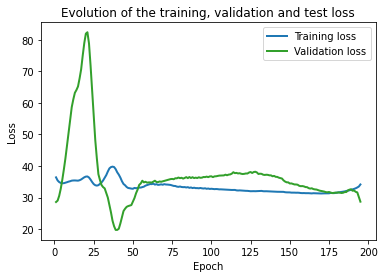

In [39]:
plot_loss(BM_reg_noexc.train_loss_history[5:], BM_reg_noexc.val_loss_history[5:])

In [40]:
# compute validation loss (burn-out first 20 epochs)
val_loss = np.mean(BM_reg_noexc.val_loss_history[-20:])

In [41]:
# Check the best models
# using calibration set to choose the best model
bm_loss_noexc, bm_model_noexc, loss_history_noexc = BM_reg_noexc.select_model()

In [43]:
# Split conformal prediction 
alpha = 0.1

# store coverage indicator for every test sample
coverage_BM_noexc = []
# store size of the prediction interval 
size_BM_noexc = []
# store test loss
test_losses_BM_noexc = []
# store prediction intervals for every test sample
pi_BM_noexc = []

# initialize
C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # find prediction interval
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model_noexc)
  pi_BM_noexc.append(benchmarkPI)
  # find size and coverage indicator
  size_BM_noexc.append(benchmarkPI[0]._measure)
  coverage_BM_noexc.append(response in benchmarkPI[0])
  # evaluate the out of sample losses
  ## load the best model
  BM_reg_noexc_temp = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=calib_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)  
  BM_reg_noexc_temp.net.load_state_dict(torch.load(bm_model_noexc, map_location=device))
  ## compute loss on test samples
  test_loss = BM_reg_noexc_temp.get_loss(input, response)
  test_losses_BM_noexc.append(test_loss)

100%|██████████| 100/100 [00:00<00:00, 108.45it/s]


In [44]:
wsc_coverages_BM_noexc = []

for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM_noexc, M=100, delta = 0.1)
  wsc_coverages_BM_noexc.append(wsc_coverage)

In [47]:
print("The marginal coverage rate is (BM no exc) {}".format(sum(coverage_BM_noexc)/len(coverage_BM_noexc)))
print("The conditional coverage rate is (BM no exc) {}".format(np.nanmean(wsc_coverages_BM_noexc)))
print("The average size is (BM no exc) {}".format(sum(size_BM_noexc)/len(size_BM_noexc)))
print("The test loss is (BM no exc) {}".format(sum(test_losses_BM_noexc)/len(test_losses_BM_noexc)))
print("The validation loss is (BM no exc) {}".format(val_loss)) 

The marginal coverage rate is (BM no exc) 0.8
The conditional coverage rate is (BM no exc) 0.7433333333333334
The average size is (BM no exc) 13.3540649414063
The test loss is (BM no exc) 34.48003005981445
The validation loss is (BM no exc) 31.559921892955906
